<a href="https://colab.research.google.com/github/cognitedata/interacting-with-open-industrial-data/blob/master/Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Visualization and Time series prediction

## What this notebook will achieve

* Extract live data from an oil rig in the North Sea.

* Visualize and inspect data directly from the Cognite Data Platform.

* Apply Linear Regression for time series prediction.


## Getting started

* Having a basic understanding of Python concepts will help to understand the process.

* Cognite has released *live* data to the public on the Cognite Data Platform streaming from [Valhall](https://www.akerbp.com/en/our-assets/production/valhall/), one of Aker's oil fields.

* To access the data, generate an API Key on [Open Industrial Data](https://openindustrialdata.com/). Get your key via the Google Access platform. You will be asked to fill out some personal information to generate your personal key.

* Visualize some of the machines (assets) on Valhall with Cognite's [Operational Intelligence](https://opint.cogniteapp.com/publicdata/infographics/-LOHKEJPLvt0eRIZu8mE) dashboard. This data on this page shows is streaming live data from the Valhall oil field located in the North Sea.

* To understand how to interact with the data using the Python SDK ([Docs](https://cognite-sdk-python.readthedocs-hosted.com/en/latest/)) follow along in this notebook.

## Environment Setup

#### Install the Cognite SDK package

In [1]:
!pip install cognite-sdk
!pip install --upgrade numpy

Looking in indexes: https://pypi.python.org/simple, https://cognite.jfrog.io/cognite/api/pypi/snakepit/simple
Looking in indexes: https://pypi.python.org/simple, https://cognite.jfrog.io/cognite/api/pypi/snakepit/simple
Requirement already up-to-date: numpy in /Users/rebeccawiborgseyfarth/miniconda3/lib/python3.7/site-packages (1.17.4)


#### Import the required packages

In [2]:
%matplotlib inline

import os
from datetime import datetime, timedelta
from datetime import datetime
from getpass import getpass

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from cognite.client import CogniteClient

#### Connect to the Cognite Data Platform
* This client object is how all queries will be sent to the Cognite API to retrieve data.

When prompted for your API key, use the key generated by open industrial data as mentioned in the Getting Started steps.

In [3]:
client = CogniteClient(api_key=getpass("Open Industrial Data API-KEY: "),
                       project="publicdata", client_name="OID_example")

Open Industrial Data API-KEY: ········


## Accessing Cognite Data Platform (CDP)
* The CDP organizes digital information about the physical world.
* There are 6 kinds of objects stored on the CDP. Each of these objects in the CDP are labelled with a unique ID. Information regarding a specific Asset, Event, etc are often retrieved using this ID.

  * [Assets](https://doc.cognitedata.com/api/0.5/#tag/Assets) are digital representations of physical objects or groups of objects, and assets are organized into an asset hierarchy. For example, an asset can represent a water pump which is part of a subsystem on an oil platform.
  
  * [Event](https://doc.cognitedata.com/api/0.5/#tag/Events) objects store complex information about multiple assets over a time period. For example, an event can describe two hours of maintenance on a water pump and some associated pipes.
  
  * A [File](https://doc.cognitedata.com/api/0.5/#tag/Files) stores a sequence of bytes connected to one or more assets. For example, a file can contain a piping and instrumentation diagram (P&IDs) showing how multiple assets are connected.
  
  * A [Time Series](https://doc.cognitedata.com/api/0.5/#tag/Time-series) consists of a sequence of data points connected to a single asset. For example: A water pump asset can have a temperature time series that records a data point in units of °C every second.
  
  * [Sequence](https://doc.cognitedata.com/api/0.5/#tag/Sequences) are similar to time series in that they are a key value pair, but rather than using a timestamp as the key, another measurment such as depth could be the key. For example, this is used in practice when drilling and taking measurments at various depths.
  
  * A [3D](https://doc.cognitedata.com/api/0.5/#tag/3D) model is typically built up by a hierarchical structure. This looks very similar to how we organize our internal asset hierarchy. 3D models are visualized via Cognite's dashboards.
  
* It is important to refer back to the [SDK](https://cognite-sdk-python.readthedocs-hosted.com/en/latest/cognite.html) for specific details on arguments on all avaiable methods on how to access these objects.

### Collecting Time Series Information and Data Points

* Time Series objects contain the bulk of information in the CDP.

* Time Series objects are generally linked to an asset through the asset_id field.

* The *get_time_series()* method has a variety of filters, all are listed in the SDK.

To get all time series available in the project, we can do like this:

In [4]:
all_timeseries = client.time_series.list(limit=-1).to_pandas()
print(len(all_timeseries))
all_timeseries.head()

363


,assetId,createdTime,description,externalId,id,isStep,isString,lastUpdatedTime,metadata,name,unit
0,3424990723231138,0,PH (Profiler) Shutdown Channel 0 - Tube y Posi...,VAL_23-LY-92529_SILch0_SC0_TYPSP:VALUE,35246780681261,False,False,0,{'tag': 'VAL_23-LY-92529_SILch0_SC0_TYPSP:VALU...,VAL_23-LY-92529_SILch0_SC0_TYPSP:VALUE,NaN
1,4293345866058133,0,PH 1stStg LO Cooler CW,VAL_45-FT-92139B:X.Value,41852231325889,False,False,0,"{'tag': 'VAL_45-FT-92139B:X.Value', 'scan': '1...",VAL_45-FT-92139B:X.Value,NaN
2,5826132550305704,0,PH 1stStg Lube Oil Reservoir,VAL_23-LT-96182-03:X.Value,44435358976768,False,False,0,"{'tag': 'VAL_23-LT-96182-03:X.Value', 'scan': ...",VAL_23-LT-96182-03:X.Value,NaN
3,7271158805875629,0,PH 1stStg Comp Thrust BRG IN,VAL_23-TT-96103-03:Z.X.Value,81505042780431,False,False,0,"{'tag': 'VAL_23-TT-96103-03:Z.X.Value', 'scan'...",VAL_23-TT-96103-03:Z.X.Value,NaN
4,6191827428964450,0,PH (SwitchGear) MV-COMP.M. FEEDER/ 51-3 Non D...,VAL_23-KA-9101-M01_OC_instantaneous_residual_N...,82185797798532,False,False,0,{'tag': 'VAL_23-KA-9101-M01_OC_instantaneous_r...,VAL_23-KA-9101-M01_OC_instantaneous_residual_N...,NaN


If you are curious about which asset a time series is attached to, you can retrieve more information of the asset by:

In [5]:
client.assets.retrieve(id=2853212781345885).to_pandas()

,value
name,23-ESDV-92501A-PST
parentId,576308321452985
description,SOFT TAG VRD - PH 1STSTGSUCTCLR GAS IN
id,2853212781345885
createdTime,0
lastUpdatedTime,0
rootId,6687602007296940
ELC_STATUS_ID,1211
SOURCE_DB,workmate
SOURCE_TABLE,wmate_dba.wmt_tag


#### View datapoints for one of the time series

* Now that we have a list of time series, we can retrieve datapoints for some of the them.

* A Datapoint in the CDP is stored as a key value pair

  * timestamp is the time since epoch in milliseconds
  
  * value is the reading from the sensor
  
The identifier to retrieve Datapoints is the **name** column from the DataFrame above.

In [6]:
client.datapoints.retrieve(external_id="VAL_45-PT-92508:X.Value", start="10d-ago", end="now").to_pandas().head()

,VAL_45-PT-92508:X.Value
2019-11-03 18:20:54.441,2.315175
2019-11-03 18:21:04.509,2.309728
2019-11-03 18:21:15.436,2.310765
2019-11-03 18:21:25.438,2.306615
2019-11-03 18:21:35.436,2.304539


## Practical use case of the data in the CDP

* When gathering data from oil platforms, specific sensors can be very expensive to install and maintain.

* A technique often used it to use a combination of other sensor readings to predict another.

* The rest of the notebook will be used to retrieve data and create the model.

#### Collect datapoints from CDP

* The following 4 columns were chosen in an effort to estimate the output pressure of the suction cooler

* Input variables:

  * FT: Input Flow Rate
  
  * PT: Input Pressure
  
  * TT: Input Temperature
  
* Output variables:

  * Output *Pressure* 
  
The time series names are defined in the *in_ts_names* and *out_ts_names* lists below.
  

In [7]:
in_ts_names = ["VAL_23-FT-92512:X.Value", "VAL_23-PT-92512:X.Value", "VAL_23-TT-92502:X.Value"]
out_ts_name = "VAL_23-PT-92504:X.Value"

#### Retrieve Data Points from CDP

* Datapoints are returned in a pandas dataframe using the method *get_datapoints_frame()*, [documentation](https://cognite-sdk-python.readthedocs-hosted.com/en/latest/cognite.html#cognite.client.stable.datapoints.DatapointsClient.get_datapoints_frame).

* The advantage of using this method over *get_datapoints()* is that the data is aggregated to a common timestamp. The processing is taken care of in the API.

* The common timestep is assigned using *granularity* argument. In this case, 1 minute was chosen.

In [8]:
ts_names = in_ts_names + [out_ts_name]

train_start_date = datetime(2018, 8, 1)
# 30 days of training data chosen arbitrarily
train_end_date = train_start_date + timedelta(days=30)

datapoints_df = client.datapoints.retrieve(external_id=ts_names,
                                           aggregates=['average'],
                                           granularity='1m',
                                           start=train_start_date,
                                           end=train_end_date
                                           ).to_pandas()
datapoints_df.fillna(method="ffill", inplace = True)
datapoints_df.head()

,VAL_23-FT-92512:X.Value|average,VAL_23-PT-92512:X.Value|average,VAL_23-TT-92502:X.Value|average,VAL_23-PT-92504:X.Value|average
2018-08-01 00:00:00,91120.918480,3.374376,44.184863,3.251437
2018-08-01 00:01:00,86259.975220,3.395966,44.232420,3.274299
2018-08-01 00:02:00,90750.665657,3.410101,44.161438,3.287578
2018-08-01 00:03:00,91948.525170,3.358822,43.986025,3.237081
2018-08-01 00:04:00,93779.111997,3.429458,43.797913,3.306391


In [9]:
datapoints_df.isna().any()

VAL_23-FT-92512:X.Value|average    False
VAL_23-PT-92512:X.Value|average    False
VAL_23-TT-92502:X.Value|average    False
VAL_23-PT-92504:X.Value|average    False
dtype: bool

In [10]:
# Remove "|average"
datapoints_df.rename(columns=lambda x: x[:-8] if x != "timestamp" else x, inplace=True)
datapoints_df.head()

,VAL_23-FT-92512:X.Value,VAL_23-PT-92512:X.Value,VAL_23-TT-92502:X.Value,VAL_23-PT-92504:X.Value
2018-08-01 00:00:00,91120.918480,3.374376,44.184863,3.251437
2018-08-01 00:01:00,86259.975220,3.395966,44.232420,3.274299
2018-08-01 00:02:00,90750.665657,3.410101,44.161438,3.287578
2018-08-01 00:03:00,91948.525170,3.358822,43.986025,3.237081
2018-08-01 00:04:00,93779.111997,3.429458,43.797913,3.306391


#### Visualize the Time Series data
* Utilize matplotlib to visualize each of the time series plots

The bottom right plot is the output time series, while the other 3 are the inputs used to create an estimate for the output.

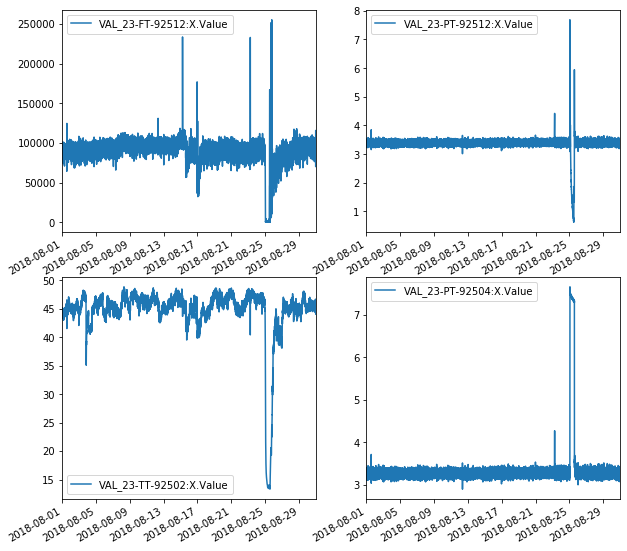

In [11]:
cols = list(datapoints_df.columns)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i, col in enumerate(cols):
    datapoints_df.loc[:, [col]].plot(ax=axes[int(i>1), i%2])

# Construct a model


### Gather the training data using the data from the figures above

In [12]:
train_X = datapoints_df[in_ts_names].values
train_y = datapoints_df[out_ts_name].values

In [31]:
datapoints_df["timestamp"] = datapoints_df.index
datapoints_df = datapoints_df.reset_index(drop=True)

### Get a seperate DataFrame from CDP for predictions

* The data which we will use to predict the output pressure will be stored in a seperate dataframe as collected below.

In [32]:
predict_start_date = train_end_date
# Make the prediction on 1 hour of data
predict_end_date = train_end_date + timedelta(hours=1)

predict_df = client.datapoints.retrieve(external_id=ts_names,
                                        aggregates=['average'],
                                        granularity='1m',
                                        start=predict_start_date,
                                        end=predict_end_date).to_pandas()
predict_df.fillna(method="ffill", inplace =True)
# Remove "|average"
predict_df.rename(columns=lambda x: x[:-8] if x != "timestamp" else x, inplace=True)
predict_df.head()

,VAL_23-FT-92512:X.Value,VAL_23-PT-92512:X.Value,VAL_23-TT-92502:X.Value,VAL_23-PT-92504:X.Value
2018-08-31 00:00:00,96596.397652,3.390761,44.822433,3.266866
2018-08-31 00:01:00,92941.748459,3.382212,44.879119,3.259393
2018-08-31 00:02:00,100634.003031,3.477319,45.053927,3.348573
2018-08-31 00:03:00,103948.895082,3.434556,45.404786,3.305596
2018-08-31 00:04:00,101079.342794,3.348590,45.698323,3.222974


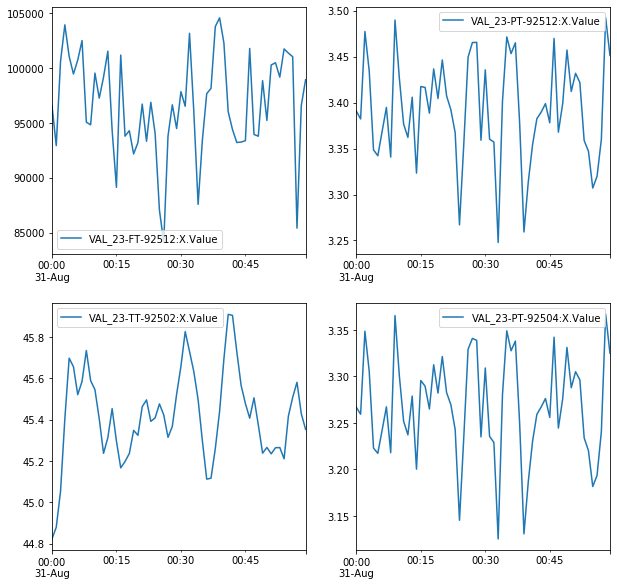

In [33]:
cols = list(predict_df.columns)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
for i, col in enumerate(cols):
    predict_df.loc[:, [col]].plot(ax=axes[int(i>1), i%2])

## Linear Regression Model

* As a simple starting point we will check to see how a linear regression model performs to predict the output pressure

### Utilize *sklearn*  to create a basic linear regression model

* Sklearn is common package utilized to import and deploy data science models. Linear Regression is only 1 of many options for constructing models.

The Mean Squared Error of our forecasts is 0.0112
The R2 score of our forecasts is -2.7284


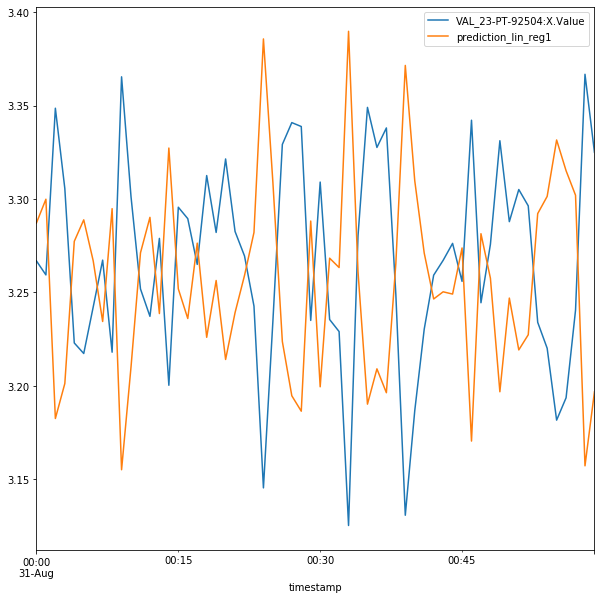

In [34]:
lin_reg = LinearRegression()
lin_reg.fit(train_X, train_y)

X = predict_df[in_ts_names].values
predict_df["prediction_lin_reg1"] = lin_reg.predict(X)
predict_df["timestamp"] = predict_df.index

# print out mse of the prediction
mse = mean_squared_error(predict_df[out_ts_name], predict_df["prediction_lin_reg1"])
r2_s = r2_score(predict_df[out_ts_name], predict_df["prediction_lin_reg1"])
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The R2 score of our forecasts is {}'.format(round(r2_s, 4)))

predict_df.plot(x="timestamp", y=[out_ts_name, "prediction_lin_reg1"], figsize=(10,10));

### Look at the fit for the training data

The Mean Squared Error on the training data is 0.0112
The R2 score of our training data is -2.7284


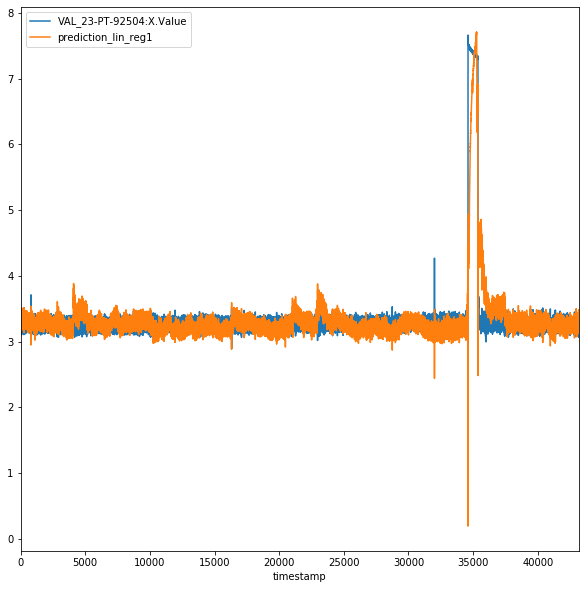

In [35]:
lin_reg = LinearRegression()
lin_reg.fit(train_X, train_y)

X = datapoints_df[in_ts_names].values
datapoints_df["prediction_lin_reg1"] = lin_reg.predict(X)

# print out mse of the prediction
mse = mean_squared_error(predict_df[out_ts_name], predict_df["prediction_lin_reg1"])
r2_s = r2_score(predict_df[out_ts_name], predict_df["prediction_lin_reg1"])
print('The Mean Squared Error on the training data is {}'.format(round(mse, 4)))
print('The R2 score of our training data is {}'.format(round(r2_s, 4)))

datapoints_df.plot(x="timestamp", y=[out_ts_name, "prediction_lin_reg1"], figsize=(10,10));

### Results

* As seen in the above, the Linear Regression model is struggling due to the anomalous period.

* One assumption of linear regression is validity of the model, that does not hold during anomalous periods.

### 1. Add dummy variable for anomalous period

In [36]:
datapoints_df['state'] = (datapoints_df[out_ts_name]< 4)*1
predict_df['state'] = (predict_df[out_ts_name]< 4)*1

The Mean Squared Error of our forecasts is 0.0021
The R2 score of our forecasts is 0.2865


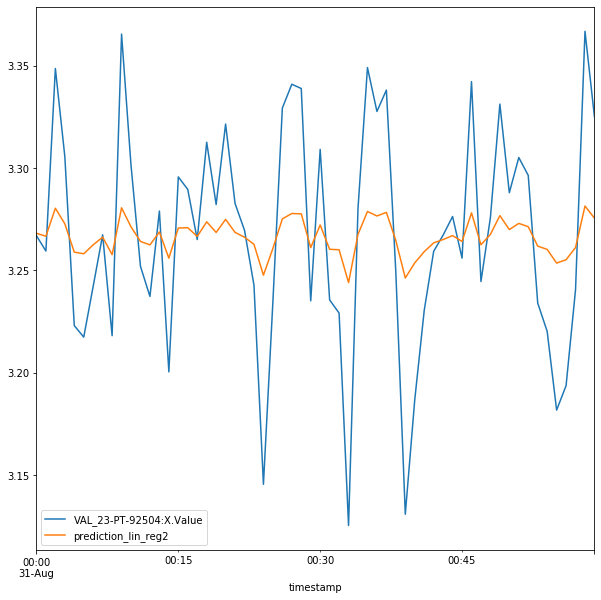

In [37]:
train_X2 = datapoints_df[in_ts_names + ['state']].values

lin_reg = LinearRegression()
lin_reg.fit(train_X2, train_y)

X = predict_df[in_ts_names + ['state']].values
predict_df["prediction_lin_reg2"] = lin_reg.predict(X)

# print out mse of the prediction
mse = mean_squared_error(predict_df[out_ts_name], predict_df["prediction_lin_reg2"])
r2_s = r2_score(predict_df[out_ts_name], predict_df["prediction_lin_reg2"])
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The R2 score of our forecasts is {}'.format(round(r2_s, 4)))

predict_df.plot(x="timestamp", y=[out_ts_name, "prediction_lin_reg2"], figsize=(10,10));

### Look at the fit for the training data

The Mean Squared Error on the training data is 0.0036
The R2 score of our training data is 0.9882


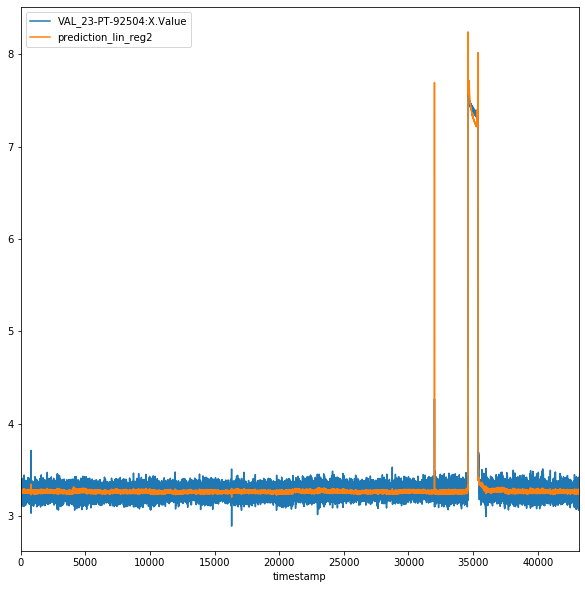

In [38]:
lin_reg = LinearRegression()
lin_reg.fit(train_X2, train_y)

X = datapoints_df[in_ts_names + ['state']].values
datapoints_df["prediction_lin_reg2"] = lin_reg.predict(X)

# print out mse of the prediction
mse = mean_squared_error(datapoints_df[out_ts_name], datapoints_df["prediction_lin_reg2"])
r2_s = r2_score(datapoints_df[out_ts_name], datapoints_df["prediction_lin_reg2"])
print('The Mean Squared Error on the training data is {}'.format(round(mse, 4)))
print('The R2 score of our training data is {}'.format(round(r2_s, 4)))

datapoints_df.plot(x="timestamp", y=[out_ts_name, "prediction_lin_reg2"], figsize=(10,10));

### Results

* The fit is better, but the model is still struggling with the anomalous period
* Big difference between training and test

### 2. Remove outliers

In [39]:
quantiles = [0.95, 0.975, 0.98, 0.99]
quantiles_df = pd.DataFrame([np.array(quantiles), np.quantile(datapoints_df[out_ts_name], q=quantiles)]).T
quantiles_df.columns = ['quantile', 'value']
quantiles_df

,quantile,value
0,0.950,3.372005
1,0.975,3.414939
2,0.980,3.503425
3,0.990,7.387873


In [40]:
datapoints_df_adj = datapoints_df.loc[datapoints_df[out_ts_name]< 4,:]

In [41]:
train_X_adj = datapoints_df_adj[in_ts_names].values
train_y_adj = datapoints_df_adj[out_ts_name].values

The Mean Squared Error of our forecasts is 0.0
The R2 score of our forecasts is 0.9995


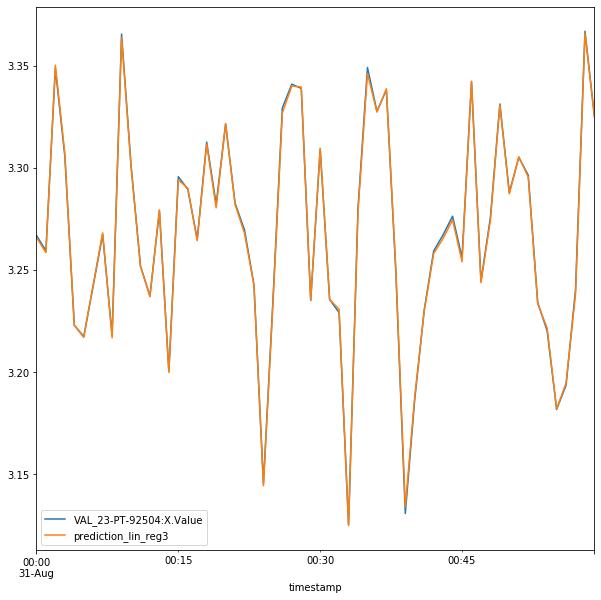

In [42]:
lin_reg = LinearRegression()
lin_reg.fit(train_X_adj, train_y_adj)

X = predict_df[in_ts_names].values
predict_df["prediction_lin_reg3"] = lin_reg.predict(X)

# print out mse of the prediction
mse = mean_squared_error(predict_df[out_ts_name], predict_df["prediction_lin_reg3"])
r2_s = r2_score(predict_df[out_ts_name], predict_df["prediction_lin_reg3"])
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The R2 score of our forecasts is {}'.format(round(r2_s, 4)))

predict_df.plot(x="timestamp", y=[out_ts_name, "prediction_lin_reg3"], figsize=(10,10));

### Look at the fit for the training data

The Mean Squared Error on the training data is 0.5937
The R2 score of our training data is -0.9575


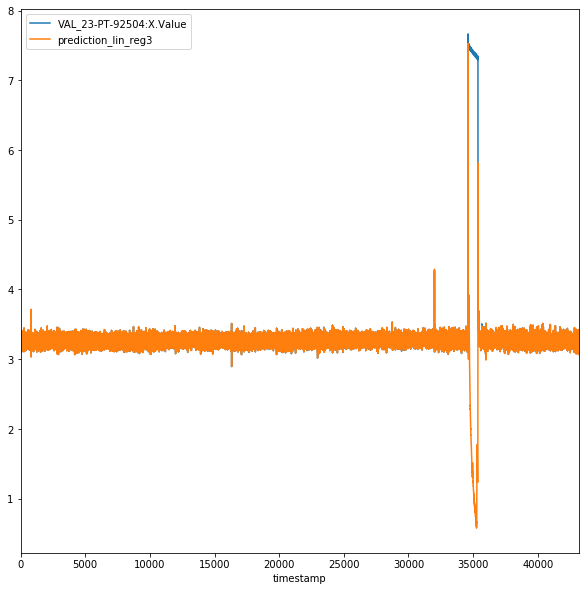

In [43]:
lin_reg = LinearRegression()
lin_reg.fit(train_X_adj, train_y_adj)

X = datapoints_df[in_ts_names].values
datapoints_df["prediction_lin_reg3"] = lin_reg.predict(X)

# print out mse of the prediction
mse = mean_squared_error(datapoints_df[out_ts_name], datapoints_df["prediction_lin_reg3"])
r2_s = r2_score(datapoints_df[out_ts_name], datapoints_df["prediction_lin_reg3"])
print('The Mean Squared Error on the training data is {}'.format(round(mse, 4)))
print('The R2 score of our training data is {}'.format(round(r2_s, 4)))

datapoints_df.plot(x="timestamp", y=[out_ts_name, "prediction_lin_reg3"], figsize=(10,10));

### Results
* The model predicts the normal period well.
* In general, parametric methods are most suited for simple problems

### Remarks:
* Linear regression is a parametric model.  
* Parametric models are simple, they are easy to understand and the results are interpretable. They are fast to train and you don't need a lot of data to train them. 
* However,  by choosing a functional form these methods are constrained to the specified form, which can result in poor fit if the assumptions are not satisfied. Parametric models are are more suited for simpler problems.
* For this use-cae a non-parametric model can result in a better fit.

## Random Forest Ensemble
* Try an alternative model to predict the pressure output

The Mean Squared Error of our forecasts is 0.0002
The R2 score of our forecasts is 0.9462


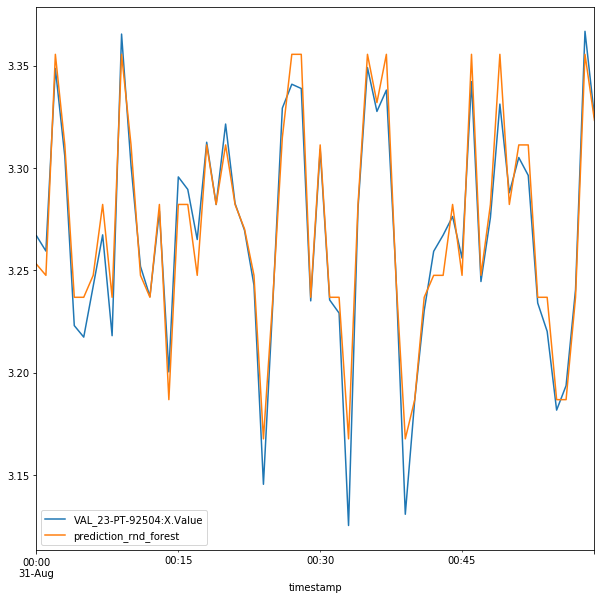

In [44]:
rnd_forest_reg = RandomForestRegressor(n_estimators=10, min_samples_split=20, max_depth=5)
rnd_forest_reg.fit(train_X, train_y)

X = predict_df[in_ts_names].values
predict_df["prediction_rnd_forest"] = rnd_forest_reg.predict(X)

# print out mse of the prediction
mse = mean_squared_error(predict_df[out_ts_name], predict_df["prediction_rnd_forest"])
r2_s = r2_score(predict_df[out_ts_name], predict_df["prediction_rnd_forest"])
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))
print('The R2 score of our forecasts is {}'.format(round(r2_s, 4)))

predict_df.plot(x="timestamp", y=[out_ts_name, "prediction_rnd_forest"], figsize=(10,10));

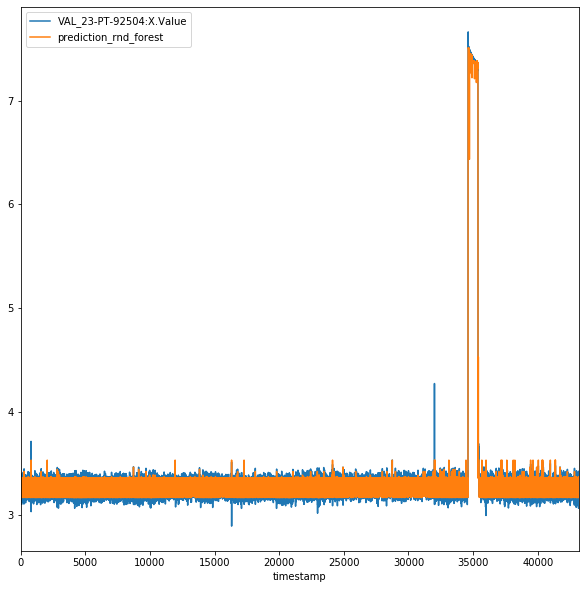

In [45]:
rnd_forest_reg = RandomForestRegressor(n_estimators=10, min_samples_split=20, max_depth=5)
rnd_forest_reg.fit(train_X, train_y)

X = datapoints_df[in_ts_names].values
datapoints_df["prediction_rnd_forest"] = rnd_forest_reg.predict(X)

datapoints_df.plot(x="timestamp", y=[out_ts_name, "prediction_rnd_forest"], figsize=(10,10));

## Anomaly detection

* Assumption: In normal periods the model results in a good fit => use size of residual as a indicator of an anomaly.

In [46]:
#Train up until 100 timestamps before anomalous period
predict_start_index = min(datapoints_df[datapoints_df[out_ts_name]> 5].index)-100

datapoints_df_ad = datapoints_df.loc[:predict_start_index, :]
train_X = datapoints_df_ad[in_ts_names].values
train_y = datapoints_df_ad[out_ts_name].values

predict_df_ad = datapoints_df.loc[predict_start_index+1:, in_ts_names + [out_ts_name, "timestamp"]]

Text(0.5, 1.0, 'VAL_23-PT-92504:X.Value')

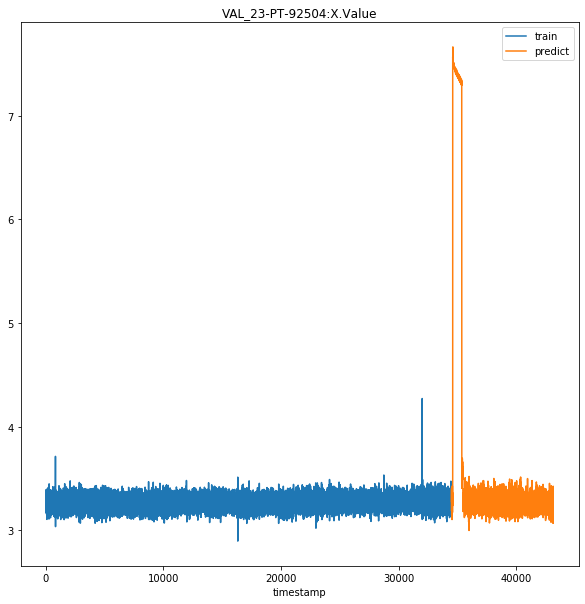

In [47]:
plt.figure(figsize=(10,10))
plt.plot(datapoints_df_ad["timestamp"], datapoints_df_ad[out_ts_name], label="train")
plt.plot(predict_df_ad["timestamp"], predict_df_ad[out_ts_name], label="predict")
plt.legend()
plt.xlabel("timestamp")
plt.title(out_ts_name)

In [48]:
rnd_forest_reg = RandomForestRegressor(n_estimators=10, min_samples_split=20, max_depth=5)
rnd_forest_reg.fit(train_X, train_y)

X = predict_df_ad[in_ts_names].values
predict_df_ad["prediction_rnd_forest"] = rnd_forest_reg.predict(X)
predict_df_ad["residual"] = np.abs(predict_df_ad["prediction_rnd_forest"]-predict_df_ad[out_ts_name])

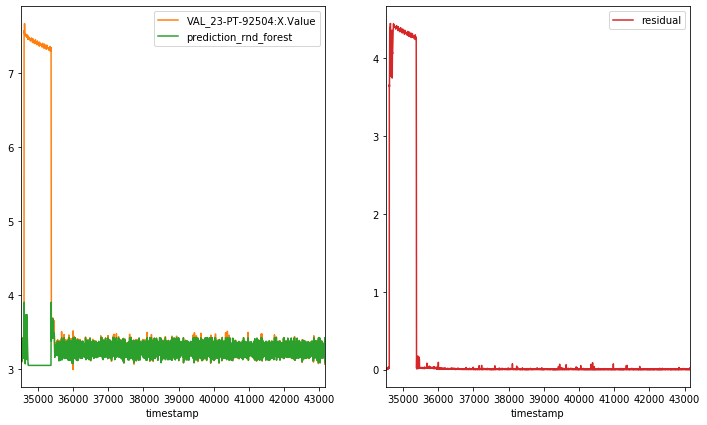

In [49]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
predict_df_ad.plot(x="timestamp", y=[out_ts_name, "prediction_rnd_forest"], figsize=(12,7), ax=ax1, 
                color=["C1", "C2"]);
predict_df_ad.plot(x="timestamp", y=["residual"], figsize=(12,7), ax=ax2, color="C3");